# Library Imports and Data Processing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import seaborn
import wandb
from wandb.keras import WandbCallback
from PIL import Image
from tqdm import tqdm
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
warnings.filterwarnings("ignore")
os.environ['KAGGLE_CONFIG_DIR'] = "../input/a-large-scale-fish-dataset"
plt.style.use("seaborn-darkgrid")
sns.set_context("paper", font_scale=1.4)

In [3]:
BATCH_SIZE = 64
EPOCHS = 15
LEARNING_RATE = 0.001
RANDOM_STATE = 42
LOSS = "categorical_crossentropy"
OPTIMIZER = "adam"
METRICS = [
    "accuracy",
    "precision",
    "recall"
]

# Helper Functions

In [4]:
def get_dataset():
  main_directory = "../input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset"
  images = []
  labels = []
  for directory in tqdm(os.listdir(main_directory)):
      next_directory = f"{main_directory}/{directory}"
      if directory in ["README.txt", "license.txt", "Segmentation_example_script.m"]:
        continue
      for images_directory in os.listdir(next_directory):
          if "GT" not in images_directory:
              final_directory = f"{next_directory}/{images_directory}"
              for image in os.listdir(final_directory):
                  images.append(np.array(Image.open(f"{final_directory}/{image}").resize((224, 224))))
                  labels.append(images_directory)
  images = np.array(images)
  labels = np.array(labels)
  return images, labels


def plot_training_images(images, labels):
  plot_images = []
  plot_labels = []
  for i, j in zip(images, labels):
    if j in plot_labels:
      continue
    else:
      plot_images.append(i)
      plot_labels.append(j)
  fig, axes = plt.subplots(nrows = 3, ncols = 3, sharex=False, figsize=(12, 12))
  for i in range(3):
    for j in range(3):
      axes[i][j].imshow(plot_images[i * 3 + j])
      axes[i][j].set_xlabel(plot_labels[i * 3 + j])
      axes[i][j].set_xticks([])
      axes[i][j].set_yticks([])
  plt.tight_layout()
  plt.show()


def get_tf_dataset(images, labels):
  return tf.data.Dataset.from_tensor_slices((images, labels)).batch(BATCH_SIZE).prefetch(1)


def split_dataset(images, labels, test_size = 0.2, valid_size = 0.2):
  train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size = test_size, random_state = RANDOM_STATE)
  train_images, valid_images, train_labels, valid_labels = train_test_split(train_images, train_labels, test_size = valid_size, random_state = RANDOM_STATE)
  return (train_images, train_labels), (valid_images, valid_labels), (test_images, test_labels)


def plot_cm(test_labels, prediction_labels, encoder):
  plt.figure(figsize=(15, 15))
  cm = confusion_matrix(test_labels, prediction_labels)
  df_cm = pd.DataFrame(cm, index = [i for i in encoder.categories_[0]],
                    columns = [i for i in encoder.categories_[0]])
  sns.set(font_scale=1.4)
  sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g') 
  plt.show()


def plot_history(history):
  fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize=(20, 10))
  # Training
  sns.lineplot(range(1, len(history.history["loss"]) + 1), history.history["loss"], ax = axes[0][0])
  sns.lineplot(range(1, len(history.history["loss"]) + 1), history.history["accuracy"], ax = axes[0][1])
  sns.lineplot(range(1, len(history.history["loss"]) + 1), history.history["precision"], ax = axes[1][0])
  sns.lineplot(range(1, len(history.history["loss"]) + 1), history.history["recall"], ax = axes[1][1])
  # Validation
  sns.lineplot(range(1, len(history.history["loss"]) + 1), history.history["val_loss"], ax = axes[0][0])
  sns.lineplot(range(1, len(history.history["loss"]) + 1), history.history["val_accuracy"], ax = axes[0][1])
  sns.lineplot(range(1, len(history.history["loss"]) + 1), history.history["val_precision"], ax = axes[1][0])
  sns.lineplot(range(1, len(history.history["loss"]) + 1), history.history["val_recall"], ax = axes[1][1])
  
  axes[0][0].set_title("Loss Comparison", fontdict = {'fontsize': 20})
  axes[0][0].set_xlabel("Epoch")
  axes[0][0].set_ylabel("Loss")

  axes[0][1].set_title("Accuracy Comparison", fontdict = {'fontsize': 20})
  axes[0][1].set_xlabel("Epoch")
  axes[0][1].set_ylabel("Accuracy")

  axes[1][0].set_title("Precision Comparison", fontdict = {'fontsize': 20})
  axes[1][0].set_xlabel("Epoch")
  axes[1][0].set_ylabel("Precision")

  axes[1][1].set_title("Recall Comparison", fontdict = {'fontsize': 20})
  axes[1][1].set_xlabel("Epoch")
  axes[1][1].set_ylabel("Recall")
  plt.tight_layout()
  plt.show()


def get_resnet(categories):
  conv_block = tf.keras.applications.resnet.ResNet50(include_top = False, weights = "imagenet")
  output = tf.keras.layers.GlobalAveragePooling2D()(conv_block.output)
  output = tf.keras.layers.Dense(categories, activation = "softmax")(output)
  model = tf.keras.Model(inputs = [conv_block.input], outputs = [output])
  return model, "ResNet50"

def plot_images(images, true_labels, predicted_labels):
    plt.figure(figsize=(25, 15))
    for i in range(min(25, len(images))):  # Plot up to 25 images
        plt.subplot(5, 5, i + 1)
        plt.imshow(images[i], cmap='gray')  # Assuming images are grayscale
        plt.title(f'True: {true_labels[i]}\nPredicted: {predicted_labels[i]}')
        plt.axis('off')
    plt.show()


# Dataset Preprocessing

In [5]:
images, labels = get_dataset()
(train_images, train_labels), (valid_images, valid_labels), (test_images, test_labels) = split_dataset(images, labels)
encoder = OneHotEncoder(sparse = False)
train_labels = encoder.fit_transform(train_labels.reshape(-1, 1))
valid_labels = encoder.transform(valid_labels.reshape(-1, 1))
test_labels = encoder.transform(test_labels.reshape(-1, 1))
train_dataset = get_tf_dataset(train_images, train_labels)
valid_dataset = get_tf_dataset(valid_images, valid_labels)

100%|██████████| 12/12 [03:21<00:00, 16.81s/it]


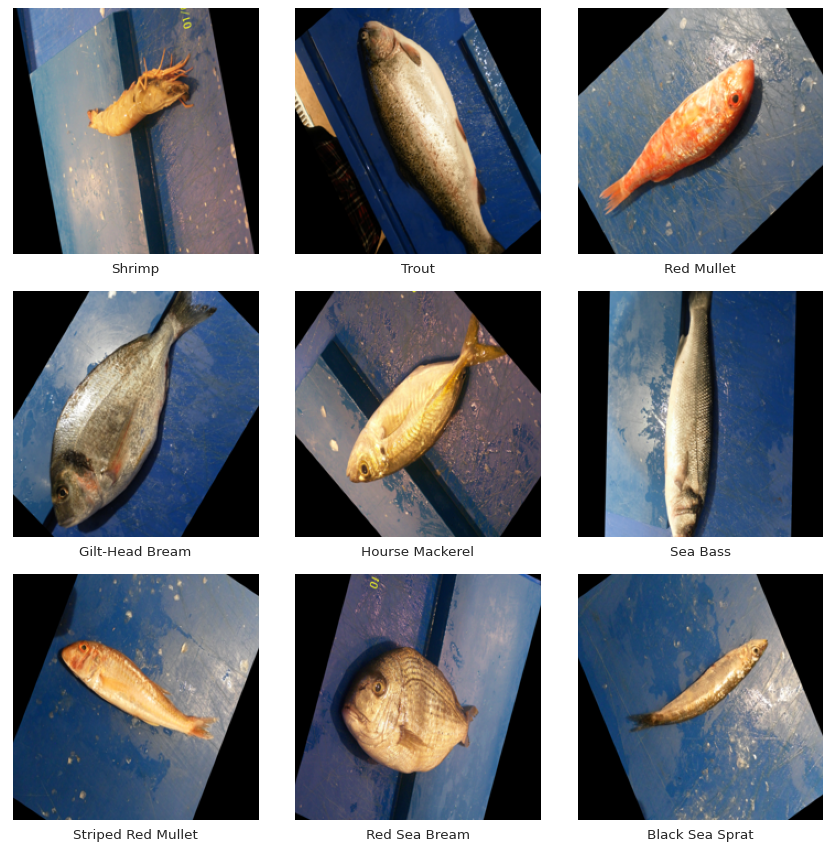

In [6]:
plot_training_images(train_images, encoder.inverse_transform(train_labels).reshape(-1,))

# ResNet50

In [7]:
model, model_name = get_resnet(len(encoder.categories_[0]))
config_defaults = {
  "learning_rate": LEARNING_RATE,
  "epochs": EPOCHS,
  "batch_size": BATCH_SIZE,
  "model_name": model_name,
  "loss": LOSS,
  "random_state": RANDOM_STATE,
  "optimizer": OPTIMIZER,
  "metrics": METRICS
}
#wandb.init(project="Fish_Dataset_Classification", id="resnet50", config = config_defaults)
model.compile(loss = LOSS, optimizer = OPTIMIZER, metrics = ["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

94781440/94765736 [==============================] - 1s 0us/step


In [8]:
history = model.fit(train_dataset,
                    validation_data = valid_dataset, 
                    batch_size = BATCH_SIZE,
                    epochs = EPOCHS, 
                    callbacks = [tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience = 5, restore_best_weights = True)])

Epoch 1/15
90/90 [==============================] - 44s 346ms/step - loss: 0.3516 - accuracy: 0.9026 - precision: 0.9385 - recall: 0.8738 - val_loss: 56.9460 - val_accuracy: 0.3313 - val_precision: 0.3319 - val_recall: 0.3306
Epoch 2/15
90/90 [==============================] - 30s 330ms/step - loss: 0.0704 - accuracy: 0.9842 - precision: 0.9860 - recall: 0.9812 - val_loss: 2.9179 - val_accuracy: 0.6569 - val_precision: 0.6592 - val_recall: 0.6528
Epoch 3/15
90/90 [==============================] - 30s 330ms/step - loss: 0.0104 - accuracy: 0.9976 - precision: 0.9977 - recall: 0.9972 - val_loss: 0.1127 - val_accuracy: 0.9625 - val_precision: 0.9698 - val_recall: 0.9590
Epoch 4/15
90/90 [==============================] - 30s 331ms/step - loss: 0.0011 - accuracy: 0.9998 - precision: 0.9998 - recall: 0.9998 - val_loss: 0.0028 - val_accuracy: 0.9993 - val_precision: 0.9993 - val_recall: 0.9993
Epoch 5/15
90/90 [==============================] - 30s 330ms/step - loss: 0.0086 - accuracy: 0.998

In [9]:
model.save("fishmodel50.h5")

In [10]:
result_inter = model.predict(test_images)
prediction_index = np.argmax(result_inter, axis = -1)
result = np.zeros(shape = test_labels.shape, dtype = test_labels.dtype)
for i in range(result.shape[0]):
  result[i][prediction_index[i]] = 1.0

In [11]:
test_labels = encoder.inverse_transform(test_labels)
prediction_labels = encoder.inverse_transform(result)

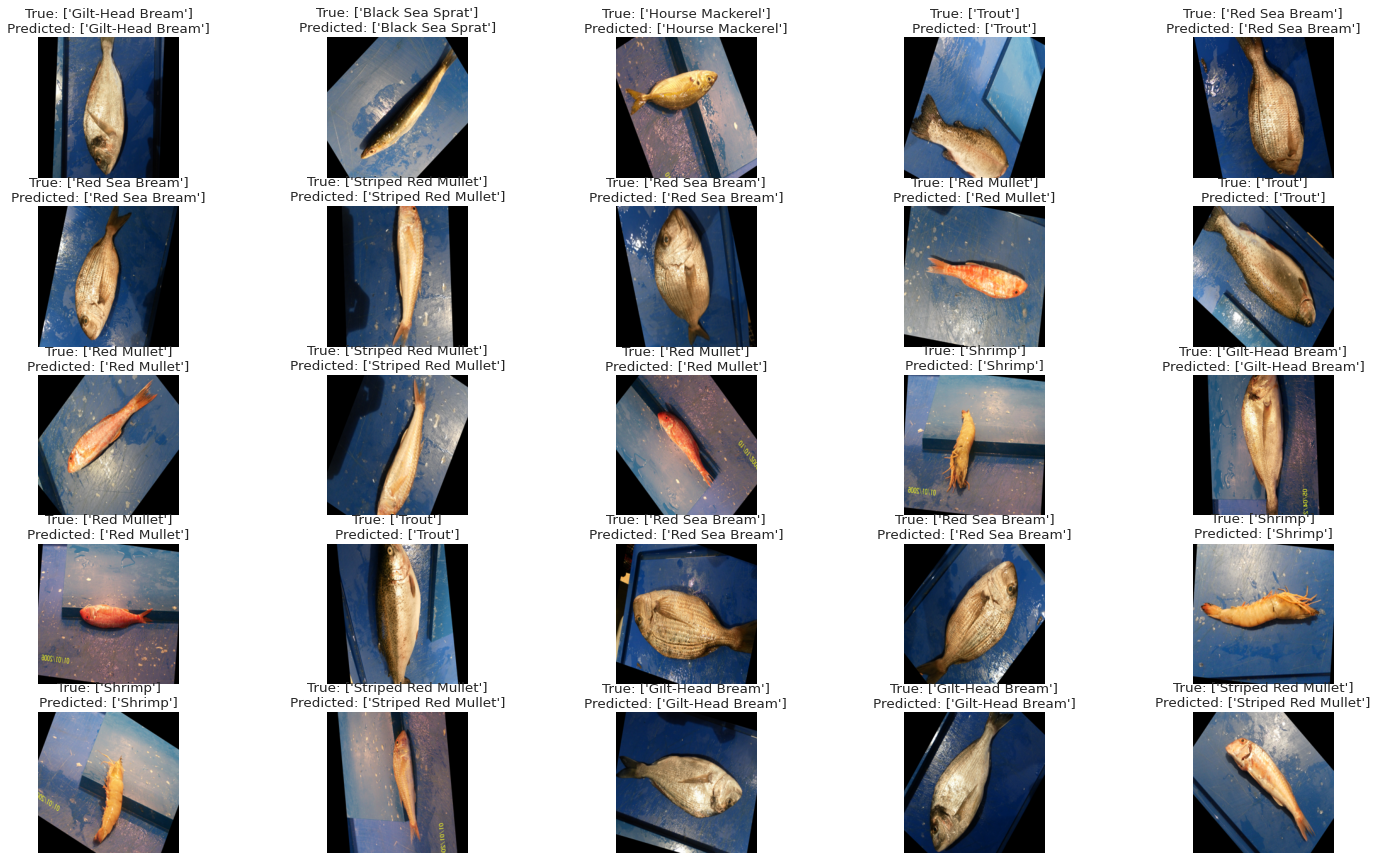

In [12]:
plot_images(test_images, test_labels, prediction_labels)

In [13]:
print(classification_report(test_labels, prediction_labels))

                    precision    recall  f1-score   support

   Black Sea Sprat       1.00      1.00      1.00       211
   Gilt-Head Bream       0.98      1.00      0.99       204
   Hourse Mackerel       0.99      1.00      1.00       195
        Red Mullet       0.99      1.00      1.00       191
     Red Sea Bream       1.00      1.00      1.00       201
          Sea Bass       1.00      0.97      0.99       179
            Shrimp       1.00      1.00      1.00       209
Striped Red Mullet       1.00      1.00      1.00       207
             Trout       1.00      1.00      1.00       203

          accuracy                           1.00      1800
         macro avg       1.00      1.00      1.00      1800
      weighted avg       1.00      1.00      1.00      1800



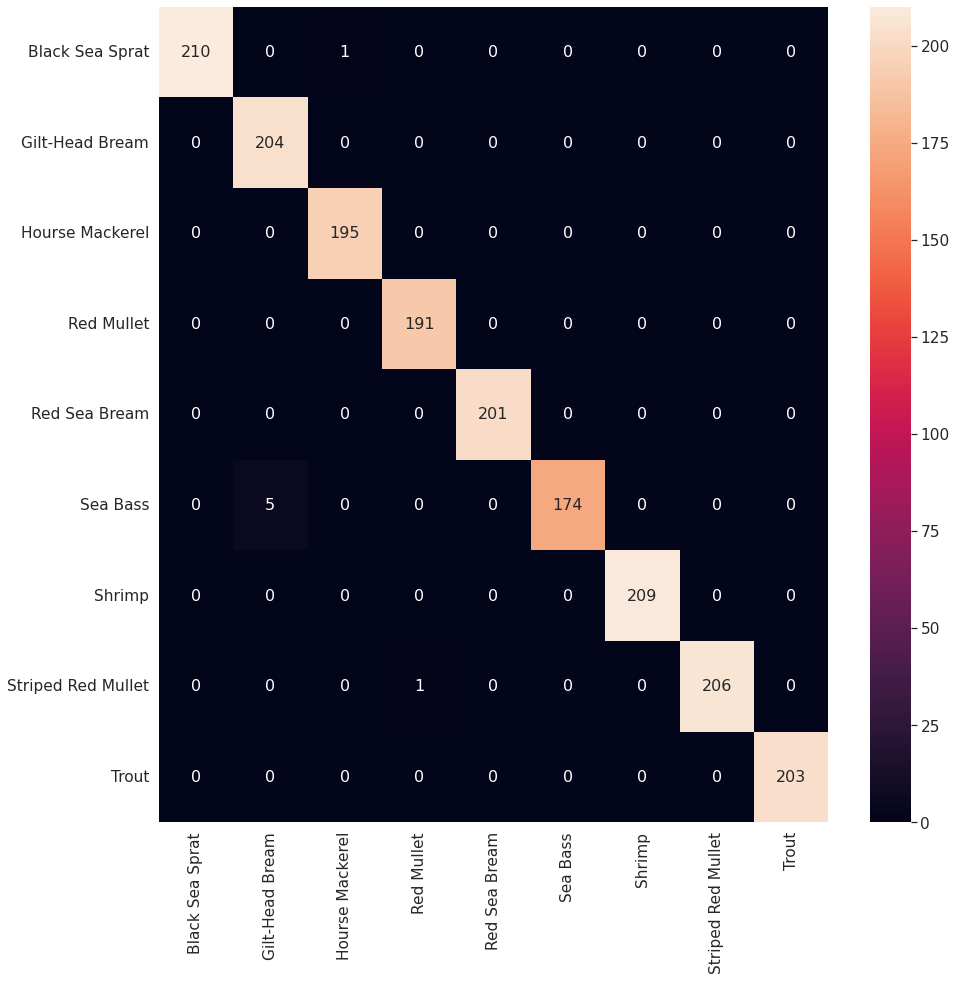

In [14]:
plot_cm(test_labels, prediction_labels, encoder)

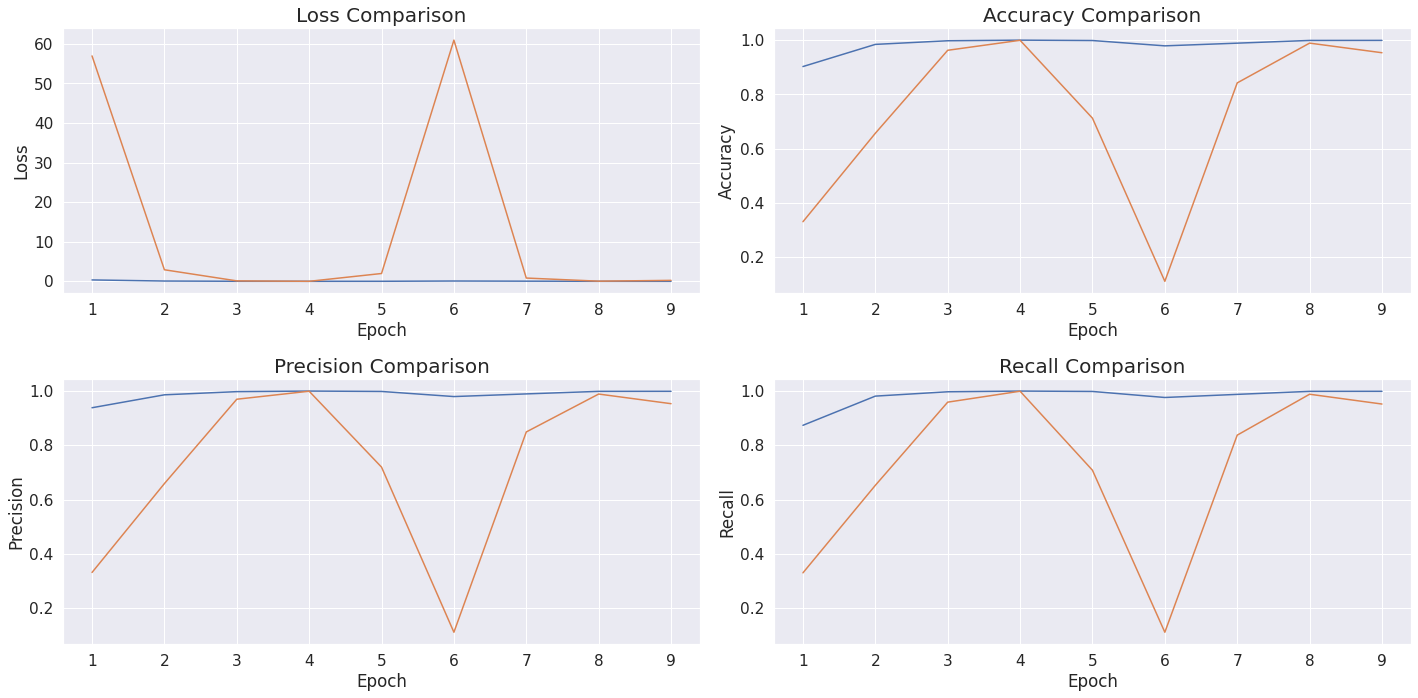

In [15]:
plot_history(history)

# Conclusions

1. The dataset is greatly designed and augmentations applied on it also help in increasing the size of the dataset without hampering the quality

2. As weights from imagenet are used, transfer learning is able to achieve such great performance as imagenet consists of a class named fish already. Just classifying fish into multiple categories is the task left in this case which has been done by transfer learning. 